## Time Series Challenge
In this challenge, we will compare the various time series prediction techniques on the dataset we can find [here](https://drive.google.com/file/d/1pgZlxluv5_cbgwR5JSWu4njbYXo_06Eb/view?usp=sharing).

- moving average
- ARIMA
- Prophet
- (Stretch) LSTMs

There are several item categories in this sales dataset. You can choose your own category or predict the overall sales.

> #### Note
> We have one order in every row, thus don't forget to transform the data into a time series format first. The data can be transformed into a daily, weekly or monthly time series.

In [77]:
# imports and setup
import pandas as pd
import numpy as np

In [78]:
data = pd.read_excel('Superstore.xls')

In [79]:
data.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [80]:
# select only Order Date, Product ID, and Sales columns
data = data[['Order Date', 'Sales']]

In [81]:
data.head(2)

,Order Date,Sales
0,2016-11-08,261.96
1,2016-11-08,731.94


In [82]:
# group sales by Order Date
data = data.groupby('Order Date')['Sales'].sum().reset_index()
data.head(2)

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060


In [83]:
# sort order dates descending
data = data.sort_values('Order Date', ascending=True)
data.head(2)

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060


In [84]:
import copy
df = copy.deepcopy(data)

In [85]:
# convert Order Date year and month only
data['Order_Date'] = pd.to_datetime(data['Order Date']).dt.to_period('M')
data.drop('Order Date', axis=1)

# group sales by Order_Date
data = data.groupby('Order_Date')['Sales'].sum().reset_index()
data.head(2)
data.isnull().sum()

Order_Date    0
Sales         0
dtype: int64

In [86]:
# convert data to pandas series, set index to Order_Date
series = data.set_index('Order_Date')['Sales']
series.head(2)


Order_Date
2014-01    14236.895
2014-02     4519.892
Freq: M, Name: Sales, dtype: float64

In [87]:
type(series)

pandas.core.series.Series

**Moving Average**
---

MA assumes 
These components are defined as follows:\

`Level:` The average value in the series.\
`Trend:` The increasing or decreasing value in the series.\
`Seasonality:` The repeating short-term cycle in the series.\
`Noise:` The random variation in the series.

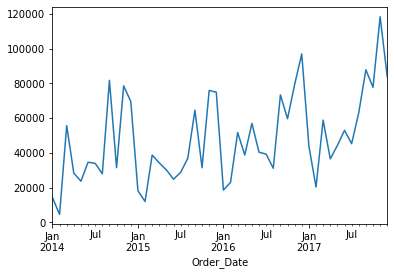

In [88]:
# Check for trends. 
from matplotlib import pyplot
series.plot()
pyplot.show()

In [89]:
# decompose time series into trend, seasonal, and residual components
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(series, model='multiplicative', period=12)


In [90]:
# get decomposed components

trend = result.trend
seasonal = result.seasonal
residual = result.resid


predicted=9378.393500, expected=55691.009000
predicted=30105.450500, expected=28295.345000
predicted=41993.177000, expected=23648.287000
predicted=25971.816000, expected=34595.127600
predicted=29121.707300, expected=33946.393000
predicted=34270.760300, expected=27909.468500
predicted=30927.930750, expected=81777.350800
predicted=54843.409650, expected=31453.393000
predicted=56615.371900, expected=78628.716700
predicted=55041.054850, expected=69545.620500
predicted=74087.168600, expected=18174.075600
predicted=43859.848050, expected=11951.411000
predicted=15062.743300, expected=38726.252000
predicted=25338.831500, expected=34195.208500
predicted=36460.730250, expected=30131.686500
predicted=32163.447500, expected=24797.292000
predicted=27464.489250, expected=28765.325000
predicted=26781.308500, expected=36898.332200
predicted=32831.828600, expected=64595.918000
predicted=50747.125100, expected=31404.923500
predicted=48000.420750, expected=75972.563500
predicted=53688.743500, expected=74

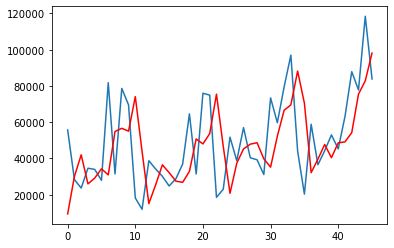

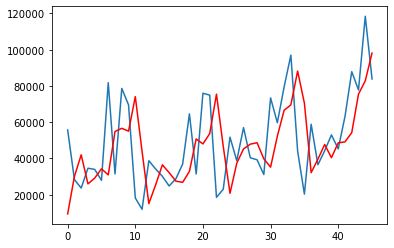

In [92]:
from pandas import read_csv
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
# prepare situation
X = series.values
window = 2
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
	length = len(history)
	yhat = mean([history[i] for i in range(length-window,length)])
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()
# zoom plot
pyplot.plot(test[0:100])
pyplot.plot(predictions[0:100], color='red')
pyplot.show()

**ARIMA**
---

In [93]:
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -537.982
Date:                Fri, 02 Jun 2023   AIC                           1087.964
Time:                        21:49:10   BIC                           1099.065
Sample:                    01-31-2014   HQIC                          1092.141
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5594      0.184     -3.034      0.002      -0.921      -0.198
ar.L2         -0.3610      0.189     -1.915      0.055      -0.731       0.008
ar.L3         -0.1578      0.220     -0.717      0.4

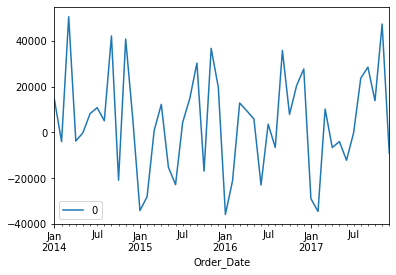

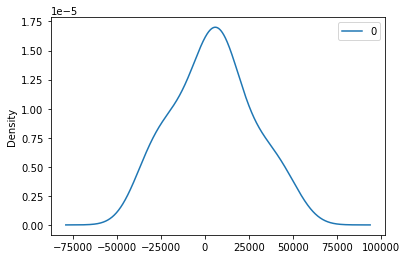

                  0
count     48.000000
mean    4510.367152
std    22274.401258
min   -35791.984631
25%    -9783.343932
50%     5422.964833
75%    16104.176020
max    50526.109248


In [98]:
# series.index = series.index.to_period('M')
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [100]:
from math import sqrt

predicted=58634.344237, expected=18542.491000
predicted=53552.413589, expected=22978.815000
predicted=43177.528113, expected=51715.875000
predicted=28569.563372, expected=38750.039000
predicted=47907.273429, expected=56987.728000
predicted=61486.827192, expected=40344.534000
predicted=36148.745164, expected=39261.963000
predicted=38777.382596, expected=31115.374300
predicted=40428.452872, expected=73410.024900
predicted=47496.162982, expected=59687.745000
predicted=55241.985078, expected=79411.965800
predicted=61775.590832, expected=96999.043000
predicted=72689.894627, expected=43971.374000
predicted=55824.428685, expected=20301.133400
predicted=52784.337062, expected=58872.352800
predicted=49673.154626, expected=36521.536100
predicted=51301.534670, expected=44261.110200
predicted=69264.039136, expected=52981.725700
predicted=46097.514816, expected=45264.416000
predicted=37045.673064, expected=63120.888000
predicted=58420.886748, expected=87866.652000
predicted=61586.768086, expected=7

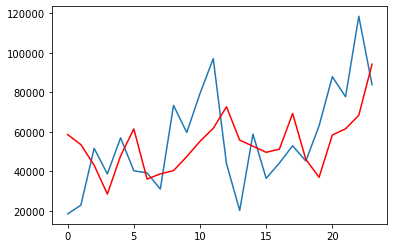

In [103]:
X = series.values
size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

**Prophet**
---